In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn
import pandas as pd
import numpy as np

In [3]:
pd.set_option('display.max_columns', 50)

## EDA

In [5]:
df_train = pd.read_csv('../data/real_estate/train_data.csv')
df_train.head(20)

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第４四半期,改装済,NaN,66.0
1,2,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,5,１Ｋ,20,NaN,NaN,NaN,平成15年,ＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第４四半期,未改装,NaN,19.0
2,3,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,3,１ＬＤＫ,45,NaN,NaN,NaN,平成24年,ＲＣ,住宅,その他,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第３四半期,未改装,NaN,37.0
3,4,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,5,１Ｒ,20,NaN,NaN,NaN,平成15年,ＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第３四半期,未改装,NaN,18.0
4,5,宅地(土地と建物),商業地,13101,東京都,千代田区,飯田橋,飯田橋,3,NaN,80,ほぼ台形,6.8,330,昭和61年,ＲＣ,住宅、事務所、店舗,事務所,南西,区道,8.0,商業地域,80.0,500.0,2017年第２四半期,NaN,NaN,240.0
5,6,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第２四半期,改装済,NaN,65.0
6,7,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,4,２ＬＤＫ,55,NaN,NaN,NaN,平成11年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第２四半期,未改装,NaN,53.0
7,8,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,NaN,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第２四半期,未改装,NaN,65.0
8,9,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第２四半期,未改装,NaN,56.0
9,10,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,3,１Ｋ,20,NaN,NaN,NaN,昭和60年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,700.0,2017年第１四半期,未改装,NaN,15.0


### 取引金額y

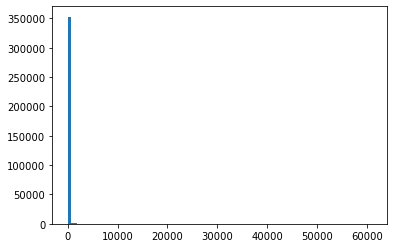

In [8]:
plt.hist(df_train['y'], bins=100);

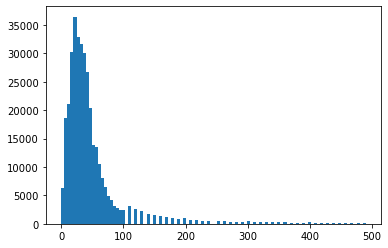

In [13]:
plt.hist(df_train.loc[df_train['y']<500, 'y'], bins=100);

偏りが大きいので対数をとる

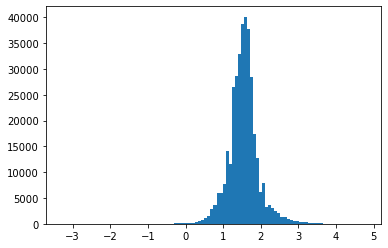

In [15]:
plt.hist(np.log10(df_train['y']), bins=100);

### 種類
不動産の種類  
（「宅地(土地/土地と建物)」「中古マンション等」「農地」「林地」など）  
「宅地（土地）」:土地のみの取引  
定義は下記の通り  
「宅地（土地と建物）」:土地と建物等を一括して取引  
「中古マンション等」:区分所有物件（戸単位）の取引

In [25]:
df_train['種類'].value_counts()

中古マンション等     158943
宅地(土地と建物)    125344
宅地(土地)        71594
林地              381
農地               82
Name: 種類, dtype: int64

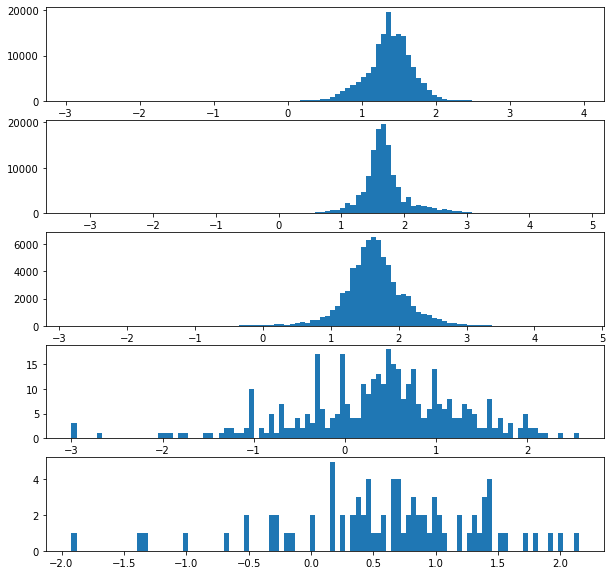

In [24]:
fig, axes = plt.subplots(5, figsize=(10, 10))
for i, estate_type in enumerate(df_train['種類'].unique()):
    is_the_type = df_train['種類'] == estate_type
    axes[i].hist(np.log10(df_train.loc[is_the_type, 'y']), bins=100)

### 市区町村名

In [26]:
df_train['市区町村名'].value_counts()

世田谷区        23288
大田区         19705
練馬区         19655
足立区         16309
杉並区         15654
板橋区         13973
八王子市        13212
江戸川区        12670
江東区         12540
新宿区         12121
品川区         11771
葛飾区         11151
港区          11001
町田市          9910
豊島区          8928
中野区          8548
文京区          8498
中央区          8421
渋谷区          8169
墨田区          7909
北区           7337
目黒区          7191
台東区          6828
府中市          5841
調布市          5359
荒川区          5356
西東京市         4570
小平市          4516
日野市          4179
立川市          4146
三鷹市          3754
千代田区         3673
青梅市          3661
東村山市         3452
国分寺市         2988
多摩市          2901
東久留米市        2681
小金井市         2681
武蔵野市         2571
昭島市          2437
あきる野市        2083
東大和市         1821
狛江市          1811
稲城市          1766
国立市          1648
武蔵村山市        1601
清瀬市          1586
羽村市          1235
福生市          1109
西多摩郡瑞穂町       796
西多摩郡日の出町      449
大島町           295
八丈町           233
西多摩郡奥多摩町      141
三宅村            72
小笠原村      

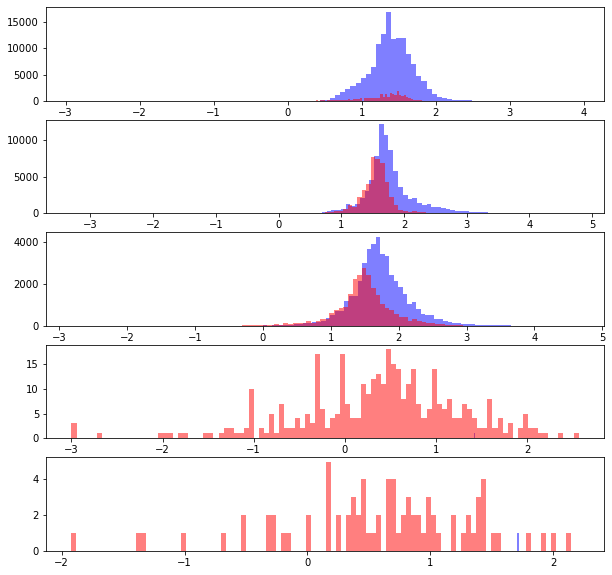

In [83]:
fig, axes = plt.subplots(5, figsize=(10, 10))
for i, estate_type in enumerate(df_train['種類'].unique()):
    is_the_type = df_train['種類'] == estate_type
    axes[i].hist(np.log10(df_train.loc[is_the_type & is_ku, 'y']), bins=100, color='blue', alpha=0.5)
    axes[i].hist(np.log10(df_train.loc[is_the_type & ~is_ku, 'y']), bins=100, color='red', alpha=0.5)

### 面積

In [27]:
df_train['面積（㎡）'].head()

0    55
1    20
2    45
3    20
4    80
Name: 面積（㎡）, dtype: object

In [28]:
s = pd.to_numeric(df_train['面積（㎡）'], errors='coerce')

全体の0.366%は、面積が数値でない

In [36]:
print('%d(%f)' % (s.isnull().sum(), s.isnull().mean()))

1305(0.003662)


面積が文字列となっているレコードは、2000㎡以上か5000㎡以上の値になっている

In [39]:
df_train.loc[s.isnull(), '面積（㎡）'].value_counts()

2000㎡以上    1208
5000㎡以上      97
Name: 面積（㎡）, dtype: int64

In [40]:
df_train.loc[s.isnull(), '種類'].value_counts()

宅地(土地)       820
宅地(土地と建物)    387
林地            95
農地             2
中古マンション等       1
Name: 種類, dtype: int64

In [49]:
df_train[(df_train['種類']=='中古マンション等') & s.isnull()]

,id,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,y
1917,1918,中古マンション等,NaN,13102,東京都,中央区,京橋,京橋(東京),0,オープンフロア,2000㎡以上,NaN,NaN,NaN,平成28年,ＳＲＣ,NaN,事務所,NaN,NaN,NaN,商業地域,80.0,700.0,2016年第４四半期,改装済,NaN,8600.0


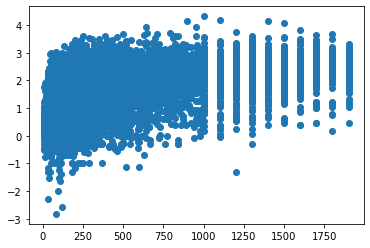

In [62]:
is_the = (df_train['種類']=='宅地(土地)') & s.notnull()
s[is_the].head()

# tmp = df_train[(df_train['種類']=='宅地(土地)') & s.notnull()]
plt.plot(s[is_the], np.log10(df_train.loc[is_the, 'y']), 'o');

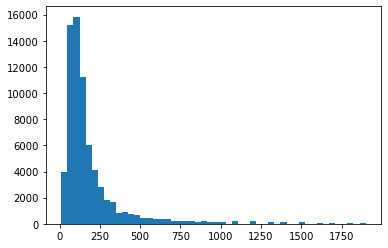

In [63]:
plt.hist(s[is_the], bins=50);